In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heartpy as hp
from scipy.signal import butter, filtfilt, iirnotch, welch
from scipy.integrate import trapezoid
import json
import os

plt.style.use('ggplot')

C:\Users\tanve\OneDrive\Desktop\NeuroSync\.venv\Lib\site-packages\heartpy\datautils.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
file_path = 'muse_data.npz'

if not os.path.exists(file_path):
    print(f"Error: {file_path} not found.")
else:
    print(f"Loading data from {file_path}...")
    data = np.load(file_path, allow_pickle=True)

    # Extract the data streams
    eeg_data = data['eeg.npy']
    ppg_raw = data['ppg.npy']

    # --- Transpose to (Samples, Channels) ---
    if eeg_data.shape[0] < eeg_data.shape[1]:
        eeg_data = eeg_data.T

    # --- Handle multi-channel PPG data ---
    if ppg_raw.ndim > 1 and ppg_raw.shape[0] < ppg_raw.shape[1]:
        ppg_data = ppg_raw[0, :] # Select first PPG channel
    else:
        ppg_data = ppg_raw.flatten()

    # --- Extract metadata ---
    sampling_rates = data['sampling_rates.npy'].item()
    
    # --- CRITICAL: Set correct channel order ---
    channel_names = np.array(['TP9', 'AF7', 'AF8', 'TP10']) # Correct order
    
    eeg_sfreq = sampling_rates.get('eeg', 256) 
    ppg_sfreq = sampling_rates.get('ppg', 64)  

    # Print a report
    print("--- Data Report ---")
    print(f"EEG Shape: {eeg_data.shape} (Samples, Channels)")
    print(f"EEG Sampling Rate: {eeg_sfreq} Hz")
    print(f"EEG Channel Names: {channel_names}")
    print(f"PPG Shape: {ppg_data.shape} (Samples,)")
    print(f"PPG Sampling Rate: {ppg_sfreq} Hz")

Loading data from muse_data.npz...
--- Data Report ---
EEG Shape: (1280, 4) (Samples, Channels)
EEG Sampling Rate: 256 Hz
EEG Channel Names: ['TP9' 'AF7' 'AF8' 'TP10']
PPG Shape: (320,) (Samples,)
PPG Sampling Rate: 64 Hz


In [3]:
def extract_basic_eeg_features(eeg_data, eeg_sfreq, channel_names, epoch_sec=2.0, overlap_sec=1.0):
    """
    Applies minimal filtering and extracts features from ALL epochs.
    No artifact rejection.
    """
    
    # --- Step 1: Filtering (Non-negotiable) ---
    
    # Re-reference to average of TP9 and TP10
    eeg_referenced = eeg_data
    try:
        tp9_idx = np.where(channel_names == 'TP9')[0][0]
        tp10_idx = np.where(channel_names == 'TP10')[0][0]
        tp_avg = eeg_data[:, [tp9_idx, tp10_idx]].mean(axis=1, keepdims=True)
        eeg_referenced = eeg_data - tp_avg
    except Exception:
        print("Could not re-reference. Using original data.")

    # Bandpass filter (1-45 Hz)
    bp_low, bp_high = 1.0, 45.0
    nyquist = 0.5 * eeg_sfreq
    b, a = butter(N=4, Wn=[bp_low/nyquist, bp_high/nyquist], btype='bandpass')
    eeg_bandpassed = filtfilt(b, a, eeg_referenced, axis=0)

    # Notch filter (50 Hz)
    notch_freq, Q = 50.0, 30
    b_notch, a_notch = iirnotch(notch_freq, Q, fs=eeg_sfreq) 
    filtered_eeg = filtfilt(b_notch, a_notch, eeg_bandpassed, axis=0)
    print("Minimal Filtering complete.")

    # --- Step 2: Epoch & Extract Features (from ALL epochs) ---
    BANDS = {
        'delta': [1, 4],
        'theta': [4, 8],
        'alpha': [8, 12],
        'beta': [12, 30],
        'gamma': [30, 45]
    }
    
    epoch_samples = int(epoch_sec * eeg_sfreq)
    overlap_samples = int(overlap_sec * eeg_sfreq)
    step_samples = epoch_samples - overlap_samples
    
    all_epochs_features = [] # List to hold feature dicts
    
    for start in range(0, filtered_eeg.shape[0] - epoch_samples + 1, step_samples):
        end = start + epoch_samples
        epoch_data = filtered_eeg[start:end, :]
        
        epoch_features = {'start_time_sec': start / eeg_sfreq}
        
        for ch_idx in range(eeg_data.shape[1]):
            ch_name = channel_names[ch_idx] 
            freqs, psd = welch(epoch_data[:, ch_idx], fs=eeg_sfreq, nperseg=epoch_samples)
            
            ch_features = {}
            for band, (low, high) in BANDS.items():
                band_mask = (freqs >= low) & (freqs <= high)
                if not np.any(band_mask):
                    band_power = 0.0
                else:
                    band_power = trapezoid(psd[band_mask], freqs[band_mask])
                
                ch_features[band] = band_power
            
            epoch_features[ch_name] = ch_features
            
        all_epochs_features.append(epoch_features)
        
    print(f"Extracted features from {len(all_epochs_features)} epochs (no rejection).")
    
    return all_epochs_features, filtered_eeg


def extract_basic_ppg_features(ppg_data, sfreq):
    """
    Extracts basic time-domain HRV features.
    Frequency-domain (lf/hf) is ignored as signal is too short.
    """
    print(f"\nProcessing PPG data (length {len(ppg_data)} samples) at {sfreq} Hz...")
    
    measures = {}
    
    try:
        # We only care about the 'measures' dict
        _, measures = hp.process(ppg_data, sample_rate=sfreq)
        print("HeartPy processing complete.")
    except Exception as e:
        print(f"HeartPy processing failed: {e}")
        
    # Return only the basic, reliable measures
    basic_measures = {
        'bpm': measures.get('bpm'),
        'rmssd': measures.get('rmssd')
    }
    return basic_measures



Running Bare-Minimum EEG Pipeline...
Minimal Filtering complete.
Extracted features from 4 epochs (no rejection).

--- Example EEG features from first epoch ---
{
  "start_time_sec": 0.0,
  "TP9": {
    "delta": 2068.4087770613955,
    "theta": 4158.248902617573,
    "alpha": 4783.339899756193,
    "beta": 12435.05867840189,
    "gamma": 13056.022010174262
  },
  "AF7": {
    "delta": 4079.88961897186,
    "theta": 8444.524111891606,
    "alpha": 5759.692687379007,
    "beta": 6077.723426208162,
    "gamma": 4876.244964822046
  },
  "AF8": {
    "delta": 4949.319426879497,
    "theta": 9614.736389077643,
    "alpha": 5729.401377007414,
    "beta": 5354.9769203264095,
    "gamma": 4916.482405681522
  },
  "TP10": {
    "delta": 2068.4087770613955,
    "theta": 4158.248902617573,
    "alpha": 4783.339899756193,
    "beta": 12435.05867840189,
    "gamma": 13056.022010174262
  }
}

Plotting filtered EEG (all epochs)...


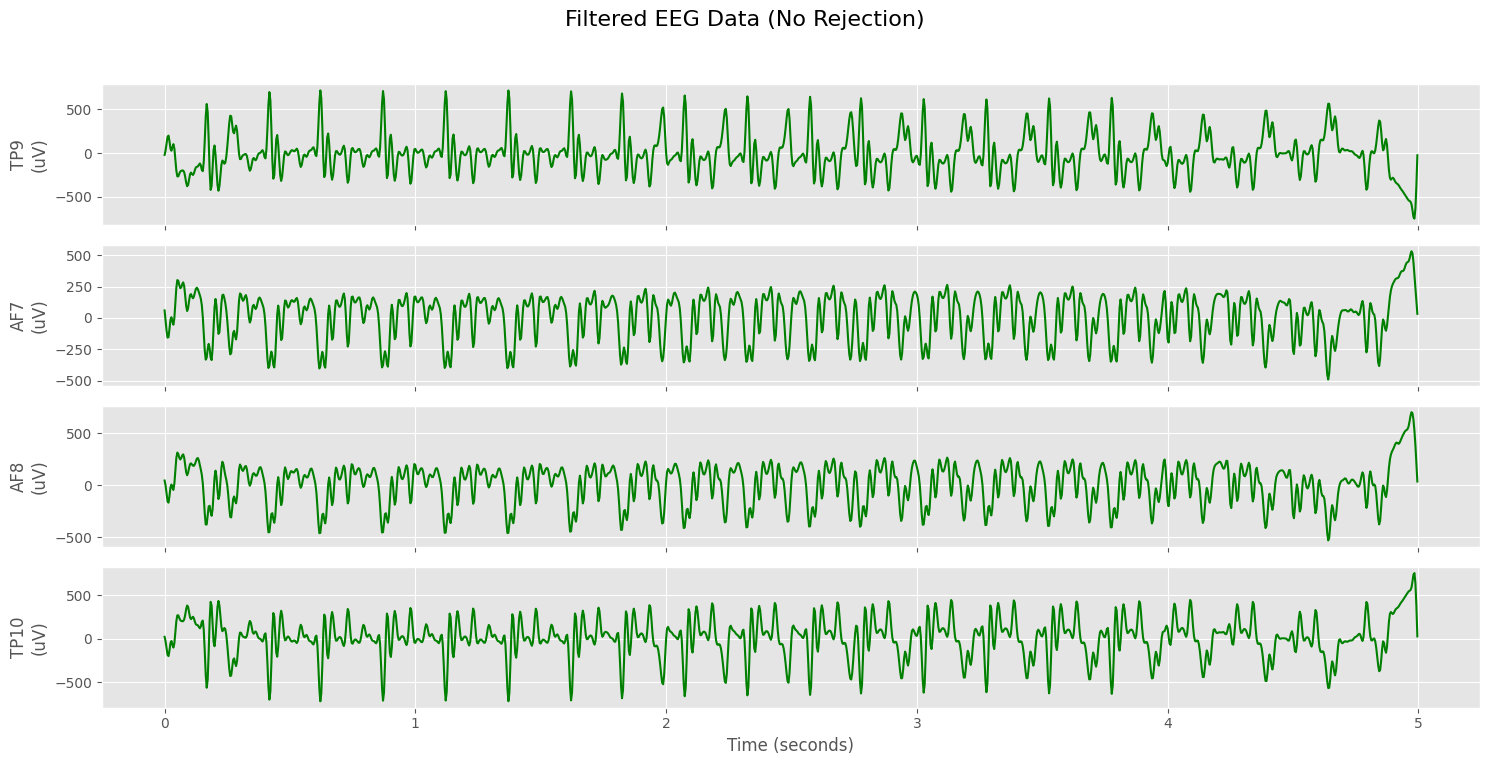


Running Bare-Minimum PPG Pipeline...

Processing PPG data (length 320 samples) at 64 Hz...
HeartPy processing failed: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------


--- Basic PPG features ---
{
  "bpm": null,
  "rmssd": null
}


In [4]:
if 'eeg_data' in locals():
    print("\nRunning Bare-Minimum EEG Pipeline...")
    eeg_features, filtered_eeg = extract_basic_eeg_features(eeg_data,
                                                            eeg_sfreq,
                                                            channel_names,
                                                            epoch_sec=2.0,
                                                            overlap_sec=1.0)
    
    print("\n--- Example EEG features from first epoch ---")
    if eeg_features:
        print(json.dumps(eeg_features[0], indent=2))
    else:
        print("No epochs were extracted.")

    # --- Plot filtered data ---
    print("\nPlotting filtered EEG (all epochs)...")
    time_axis = np.arange(filtered_eeg.shape[0]) / eeg_sfreq
    num_channels = filtered_eeg.shape[1]
    fig, axes = plt.subplots(num_channels, 1, figsize=(15, 8), sharex=True)
    fig.suptitle('Filtered EEG Data (No Rejection)', fontsize=16)
    for i in range(num_channels):
        axes[i].plot(time_axis, filtered_eeg[:, i], 'g')
        axes[i].set_ylabel(f"{channel_names[i]}\n(uV)")
    axes[-1].set_xlabel('Time (seconds)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print("Skipping EEG processing as data was not loaded.")
    eeg_features = []


if 'ppg_data' in locals():
    print("\nRunning Bare-Minimum PPG Pipeline...")
    ppg_features = extract_basic_ppg_features(ppg_data, ppg_sfreq)
    
    print("\n--- Basic PPG features ---")
    print(json.dumps(ppg_features, indent=2))
else:
    print("Skipping PPG processing as data was not loaded.")
    ppg_features = {}


In [5]:
def flatten_features(eeg_features, ppg_features):
    """
    Converts the feature dictionaries into a simple list
    of feature vectors (X) for an ML model.
    """
    X = []
    
    # These are our "column headers"
    feature_names = []
    # Get EEG feature names from one epoch (all channels, all bands)
    if eeg_features:
        first_epoch = eeg_features[0]
        for ch_name in channel_names:
            if ch_name in first_epoch:
                for band_name in first_epoch[ch_name].keys():
                    feature_names.append(f"{ch_name}_{band_name}")
    
    # Add PPG feature names
    for ppg_feature in ppg_features.keys():
        feature_names.append(f"ppg_{ppg_feature}")
        
    print(f"Created {len(feature_names)} total features for the ML model.")
    print(f"Feature names: {feature_names}")

    # Now, build the feature vector (X) for each epoch
    for epoch in eeg_features:
        feature_vector = []
        
        # Add EEG features in order
        for ch_name in channel_names:
            if ch_name in epoch:
                for band_name in epoch[ch_name].keys():
                    feature_vector.append(epoch[ch_name].get(band_name, 0))
        
        # Add the (repeating) PPG features
        for ppg_feature in ppg_features.keys():
            feature_vector.append(ppg_features.get(ppg_feature, 0))
            
        X.append(feature_vector)
        
    return np.array(X), feature_names

if eeg_features or ppg_features:
    print("\n--- Creating ML Feature Set (X) ---")
    # X is the data, feature_names are the columns
    X_data, X_names = flatten_features(eeg_features, ppg_features)
    
    print(f"\nFinal ML data shape (epochs, features): {X_data.shape}")
    print("\n--- Example Data (First Epoch) ---")
    if X_data.shape[0] > 0:
        print(X_data[0])
else:
    print("No features extracted, cannot build ML dataset.")


--- Creating ML Feature Set (X) ---
Created 22 total features for the ML model.
Feature names: ['TP9_delta', 'TP9_theta', 'TP9_alpha', 'TP9_beta', 'TP9_gamma', 'AF7_delta', 'AF7_theta', 'AF7_alpha', 'AF7_beta', 'AF7_gamma', 'AF8_delta', 'AF8_theta', 'AF8_alpha', 'AF8_beta', 'AF8_gamma', 'TP10_delta', 'TP10_theta', 'TP10_alpha', 'TP10_beta', 'TP10_gamma', 'ppg_bpm', 'ppg_rmssd']

Final ML data shape (epochs, features): (4, 22)

--- Example Data (First Epoch) ---
[np.float64(2068.4087770613955) np.float64(4158.248902617573)
 np.float64(4783.339899756193) np.float64(12435.05867840189)
 np.float64(13056.022010174262) np.float64(4079.88961897186)
 np.float64(8444.524111891606) np.float64(5759.692687379007)
 np.float64(6077.723426208162) np.float64(4876.244964822046)
 np.float64(4949.319426879497) np.float64(9614.736389077643)
 np.float64(5729.401377007414) np.float64(5354.9769203264095)
 np.float64(4916.482405681522) np.float64(2068.4087770613955)
 np.float64(4158.248902617573) np.float64(


Running EEG Pre-processing...
Found TP9 at index 0 and TP10 at index 3.
Re-referenced EEG to average of TP9 and TP10.
Found AF7 at index 1 and AF8 at index 2 for blink detection.
Calculated blink artifacts from AF7 and AF8.
EEG Pre-processing complete.
100.00% of samples flagged as artifacts.

Plotting Raw vs. Filtered EEG...


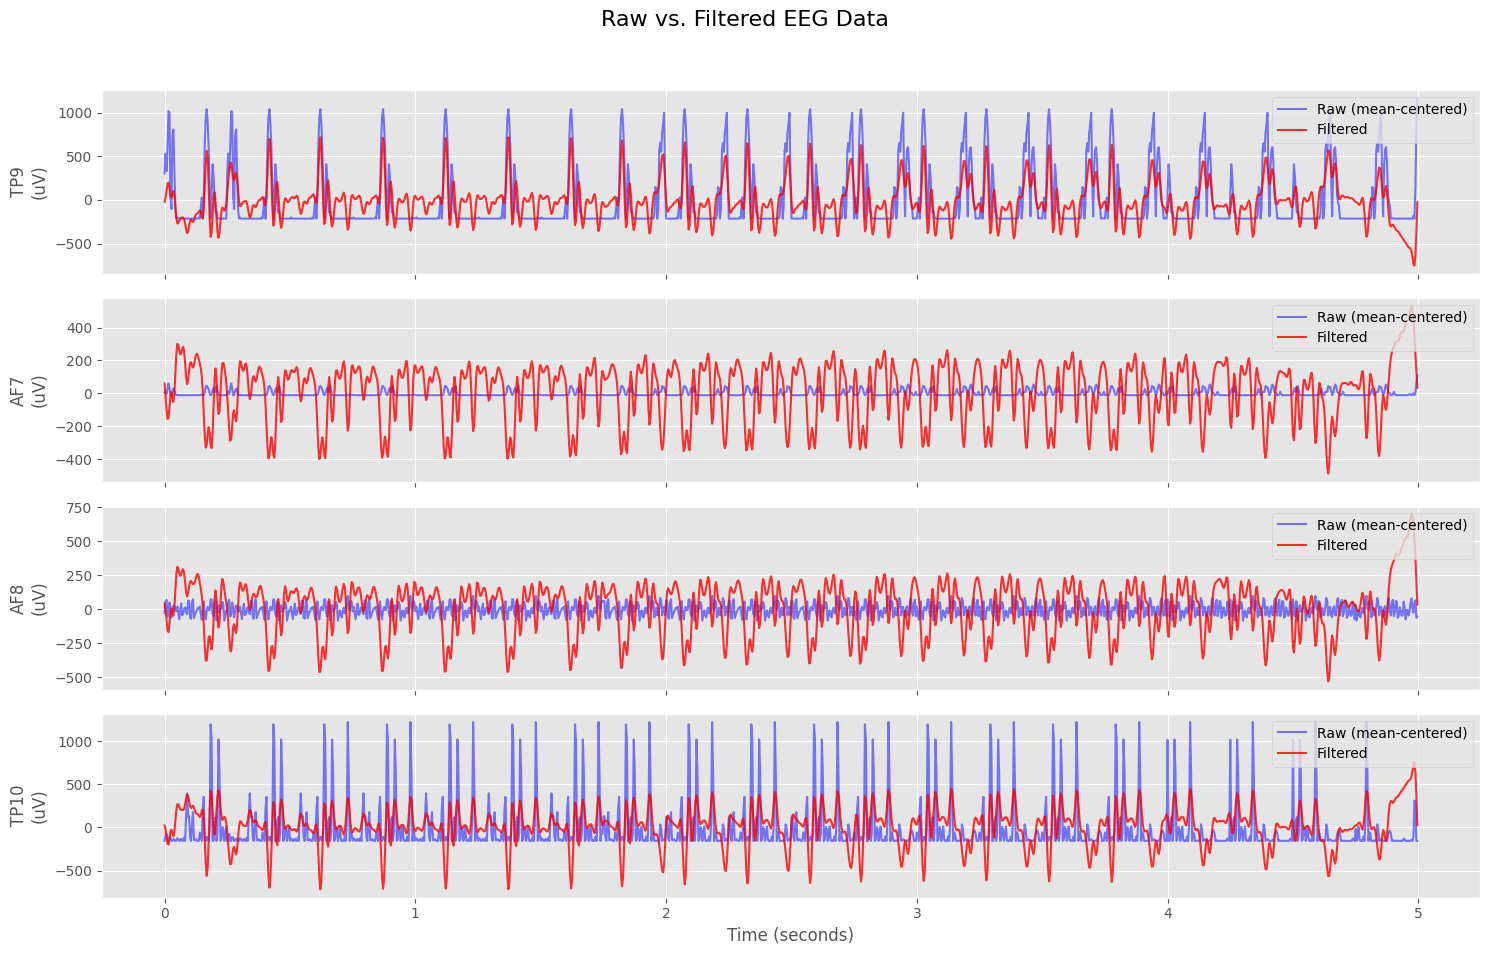


Plotting Filtered EEG with Artifact Mask...


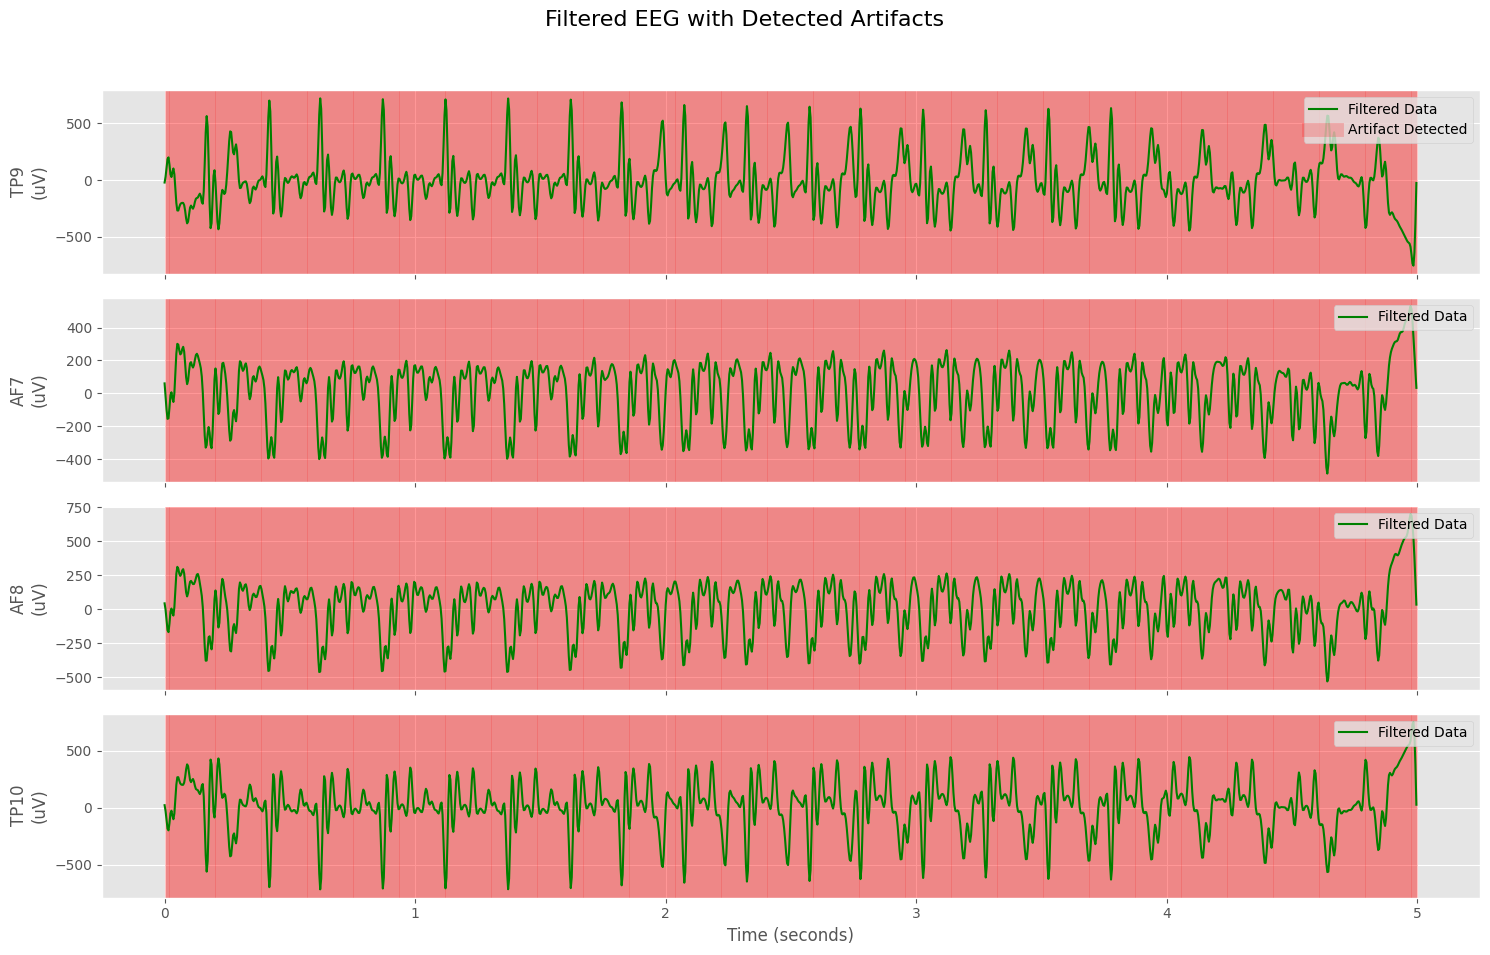

In [6]:
print("\nRunning EEG Pre-processing...")
if 'eeg_data' in locals(): # Check if data loaded successfully
    # --- FIX: Pass new sample rates to the function ---
    filtered_eeg, artifact_mask = preprocess_eeg(eeg_data, 
                                                 acc_data, 
                                                 gyro_data, 
                                                 eeg_sfreq,
                                                 acc_sfreq,
                                                 gyro_sfreq,
                                                 channel_names)
    # --- END FIX ---
    print("EEG Pre-processing complete.")
    print(f"{artifact_mask.sum() / len(artifact_mask) * 100:.2f}% of samples flagged as artifacts.")

    # --- EEG Visualization 1: Raw vs. Filtered ---
    print("\nPlotting Raw vs. Filtered EEG...")
    time_axis = np.arange(eeg_data.shape[0]) / eeg_sfreq
    num_channels = eeg_data.shape[1]

    fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Raw vs. Filtered EEG Data', fontsize=16)

    for i in range(num_channels):
        ax = axes[i]
        ch_name = channel_names[i] # This will now be the correct name
        
        # Plot Raw Data (with offset for clarity)
        raw_mean = np.mean(eeg_data[:, i])
        ax.plot(time_axis, eeg_data[:, i] - raw_mean, 'b', alpha=0.5, label='Raw (mean-centered)')
        
        # Plot Filtered Data
        ax.plot(time_axis, filtered_eeg[:, i], 'r', alpha=0.8, label='Filtered')
        
        ax.set_ylabel(f"{ch_name}\n(uV)")
        ax.legend(loc='upper right')

    axes[-1].set_xlabel('Time (seconds)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # This will open a plot window


    # --- EEG Visualization 2: Filtered Data with Artifacts ---
    print("\nPlotting Filtered EEG with Artifact Mask...")

    fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Filtered EEG with Detected Artifacts', fontsize=16)

    for i in range(num_channels):
        ax = axes[i]
        ch_name = channel_names[i] # This will now be the correct name
        
        # Plot Filtered Data
        ax.plot(time_axis, filtered_eeg[:, i], 'g', label='Filtered Data')
        
        # Shade artifact regions
        mask_indices = np.where(artifact_mask)[0]
        for start in mask_indices:
            # This is inefficient for plotting, but fine for 10s
            ax.axvspan(start/eeg_sfreq, (start+1)/eeg_sfreq, color='red', alpha=0.2)

        ax.set_ylabel(f"{ch_name}\n(uV)")
        
        # Add a custom legend entry for the artifact shading
        if i == 0:
            ax.plot([], [], color='red', alpha=0.2, linewidth=10, label='Artifact Detected')
        ax.legend(loc='upper right')

    axes[-1].set_xlabel('Time (seconds)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # This will open a second plot window

else:
    print("Skipping EEG processing as data was not loaded.")

In [7]:
if 'filtered_eeg' in locals(): # Check if previous step ran
    epoch_sec = 2.0
    overlap_sec = 1.0

    print(f"\nExtracting EEG features ({epoch_sec}s epochs, {overlap_sec}s overlap)...")

    eeg_features = extract_eeg_features(filtered_eeg, 
                                      artifact_mask, 
                                      eeg_sfreq, 
                                      channel_names, 
                                      epoch_sec, 
                                      overlap_sec)

    print(f"\nExtracted features from {len(eeg_features)} clean epochs.")

    if eeg_features:
        print("\n--- Example features from first clean epoch ---")
        print(json.dumps(eeg_features[0], indent=2))
    else:
        print("No clean epochs were found in this 10-second sample.")
else:
    print("Skipping EEG feature extraction as pre-processing did not run.")
    eeg_features = [] # Define as empty list to avoid errors



Extracting EEG features (2.0s epochs, 1.0s overlap)...
Skipping epoch 0.00s (too many artifacts)
Skipping epoch 1.00s (too many artifacts)
Skipping epoch 2.00s (too many artifacts)
Skipping epoch 3.00s (too many artifacts)

Extracted features from 0 clean epochs.
No clean epochs were found in this 10-second sample.



Plotting Raw PPG Data...


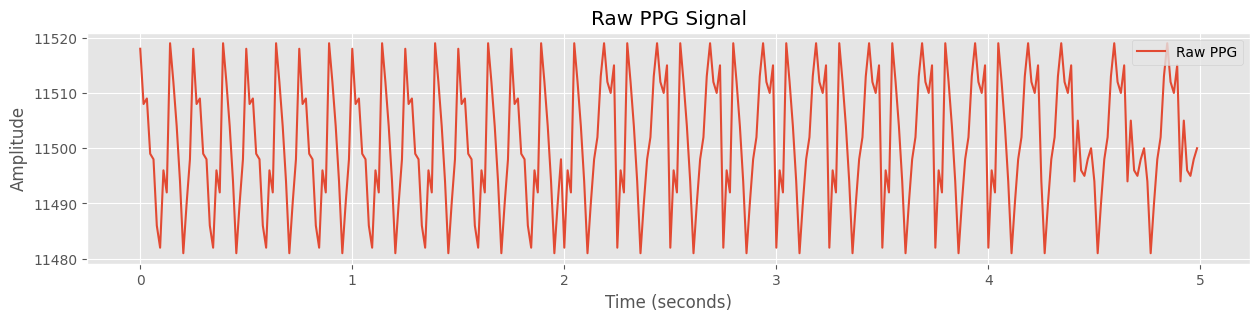

Processing PPG data (length 320 samples) at 64 Hz...
HeartPy processing failed: 
----------------
Could not determine best fit for given signal. Please check the source signal.
 Probable causes:
- detected heart rate falls outside of bpmmin<->bpmmax constraints
- no detectable heart rate present in signal
- very noisy signal (consider filtering and scaling)
If you're sure the signal contains heartrate data, consider filtering and/or scaling first.
----------------

HeartPy processing failed, skipping plot.

--- Key PPG/HRV Measures (from 10s sample) ---
  BPM (mean): N/A
  RMSSD (Time Domain HRV): N/A
  LF/HF Ratio (Freq Domain): N/A <-- SEE NOTE ABOVE


In [8]:
if 'ppg_data' in locals():
    # --- PPG Visualization 1: Raw Data ---
    print("\nPlotting Raw PPG Data...")
    ppg_time_axis = np.arange(ppg_data.shape[0]) / ppg_sfreq

    plt.figure(figsize=(15, 3))
    plt.title("Raw PPG Signal")
    plt.plot(ppg_time_axis, ppg_data, label="Raw PPG")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show() # This will open a third plot window

    # --- Run PPG Pipeline ---
    ppg_working_data, ppg_measures = preprocess_ppg_and_extract_hrv(ppg_data, ppg_sfreq)

    # --- PPG Visualization 2: HeartPy Plotter ---
    if ppg_working_data and 'filtered' in ppg_working_data:
        print("\nPlotting HeartPy Processing Results...")
        try:
            hp.plotter(ppg_working_data, ppg_measures, figsize=(15, 6))
            plt.show() # This will open a fourth plot window
        except Exception as e:
            print(f"HeartPy plotter failed: {e}. (Often due to no peaks found in short signal)")
    else:
        print("HeartPy processing failed, skipping plot.")

    print("\n--- Key PPG/HRV Measures (from 10s sample) ---")
    print(f"  BPM (mean): {ppg_measures.get('bpm', 'N/A')}")
    print(f"  RMSSD (Time Domain HRV): {ppg_measures.get('rmssd', 'N/A')}")
    print(f"  LF/HF Ratio (Freq Domain): {ppg_measures.get('lf/hf', 'N/A')} <-- SEE NOTE ABOVE")
else:
    print("Skipping PPG processing as data was not loaded.")
    ppg_measures = {} # Define as empty dict

In [9]:
print("\n--- FINAL INSIGHTS (from V1 Engine) ---")
all_insights = []
if 'eeg_features' in locals() and 'ppg_measures' in locals():
    for epoch in eeg_features:
        insight = interpret_epoch_insights_v1(epoch, ppg_measures, channel_names)
        all_insights.append(insight)
        
    print(json.dumps(all_insights, indent=2))
else:
    print("Skipping insights engine as features were not extracted.")



--- FINAL INSIGHTS (from V1 Engine) ---
[]
